In [27]:
import sys

import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import plot_sim as ps

#%matplotlib notebook
#DEFAULT_FIGSIZE = (8, 6)
%matplotlib inline 
DEFAULT_FIGSIZE = (12, 8)

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = DEFAULT_FIGSIZE

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


-5.49348569966


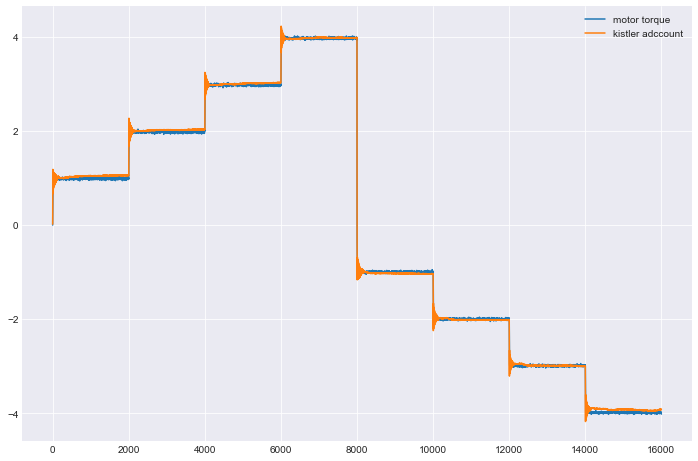

In [44]:
#log1 = ps.ProcessedRecord('logs/positive_ramp.pb.cobs')
#log2 = ps.ProcessedRecord('logs/negative_ramp.pb.cobs')
#tf = 11 # cutoff time
#log1 = ps.ProcessedRecord('logs/positive_constant.pb.cobs')
#log2 = ps.ProcessedRecord('logs/negative_constant.pb.cobs')
tf = 8 # cutoff time

n = np.where(log1.t > tf)[0][0]

torque_sensor_adccount = np.concatenate((
    log1.records.sensors.kistler_measured_torque[:n],
    log2.records.sensors.kistler_measured_torque[:n])).astype(np.float64)

measured_motor_torque = ps.get_kollmorgen_applied_torque(
    np.concatenate((
        log1.records.sensors.kollmorgen_actual_torque[:n],
        log2.records.sensors.kollmorgen_actual_torque[:n])))

from scipy.optimize import curve_fit

#def f(x, m, b):
#    return m/(2**11)*(x - b)
def f(x, m):
    return m/(2**11)*(x - 2046)

#m, b = curve_fit(f, torque_sensor_adccount, measured_motor_torque)[0]
#print(m, b)
m = curve_fit(f, torque_sensor_adccount, measured_motor_torque)[0][0]
print(m)

def get_kistler_torque(x):
    #return f(x.astype(np.float64), m, b)
    return f(x.astype(np.float64), m)

plt.close('all')
fig, ax = plt.subplots()
ax.plot(measured_motor_torque, label='motor torque')
ax.plot(get_kistler_torque(torque_sensor_adccount), label='kistler adccount')
ax.legend()
plt.show()

In [45]:
def plot_torques(log, friction=False, rescale_kistler=False):
    commanded_torque = ps.get_kollmorgen_command_torque(
        log.records.actuators.kollmorgen_command_torque)
    measured_torque = ps.get_kollmorgen_applied_torque(
        log.records.sensors.kollmorgen_actual_torque)
    if rescale_kistler:
        measured_sensor_torque = get_kistler_torque(
            log.records.sensors.kistler_measured_torque)
    else:
        measured_sensor_torque = ps.get_kistler_sensor_torque(
            log.records.sensors.kistler_measured_torque)
    
    encoder_angle = log.records.sensors.steer_encoder_count * 2*np.pi/152000
    encoder_angle[np.where(encoder_angle > np.pi)[0]] -= 2*np.pi
    
    encoder_rate = scipy.signal.savgol_filter(encoder_angle, 101, 2, 1, 0.001)
    
    if friction:
        i = np.where(np.abs(encoder_rate) > 0.1)[0][0]
    else:
        i = -1
    
    index = slice(0, i)

    plt.close('all')
    fig, ax = plt.subplots()
    ax.plot(log.t[index], commanded_torque[index],
            label='commanded motor torque')
    
    ax.plot(log.t[index],
            measured_torque[index],
            label='measured motor torque')
    
    ax.plot(log.t[index],
            measured_sensor_torque[index],
            label='measured sensor torque')
    
    ax.plot(log.t[index],
            encoder_angle[index],
            label='measured steer angle')
    
    ax.plot(log.t[index],
            encoder_rate[index],
            label='estimated steer rate')
    ax.legend()
    ax.set_xlabel('time [s]')
    ax.set_ylabel('[N-m, rad]')
    return fig, ax

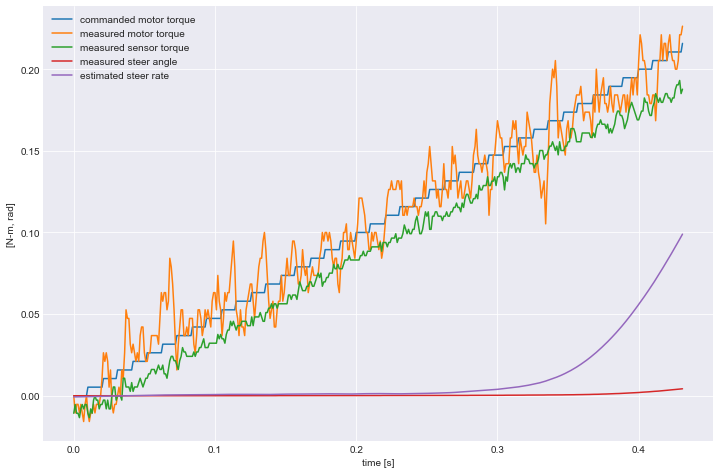

In [46]:
log = ps.ProcessedRecord('logs/positive_friction.pb.cobs')
plt.close('all')
plot_torques(log, True, True)
plt.show()

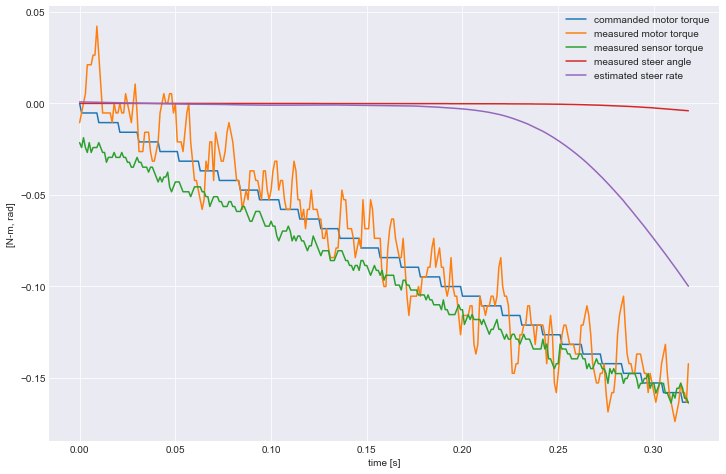

In [53]:
log = ps.ProcessedRecord('logs/negative_friction.pb.cobs')
plt.close('all')
plot_torques(log, True, True)
plt.show()

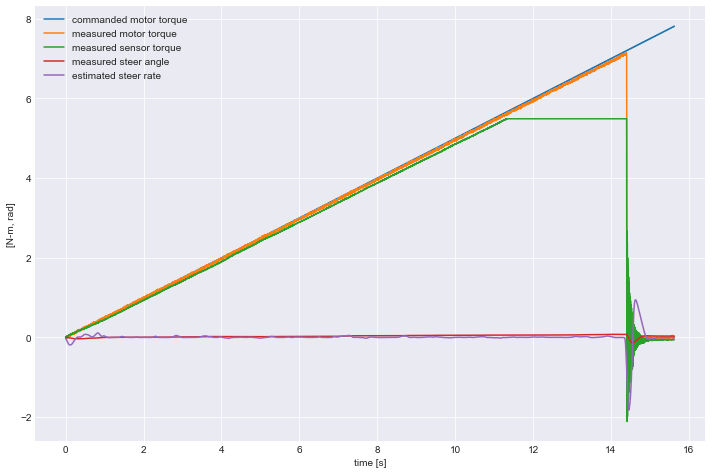

In [48]:
log = ps.ProcessedRecord('logs/positive_ramp.pb.cobs')
plt.close('all')
plot_torques(log, rescale_kistler=True)
plt.show()

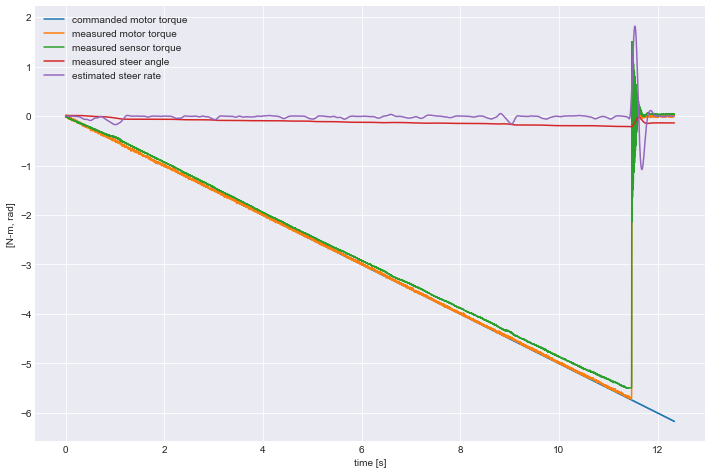

In [49]:
log = ps.ProcessedRecord('logs/negative_ramp.pb.cobs')
plt.close('all')
plot_torques(log, rescale_kistler=True)
plt.show()

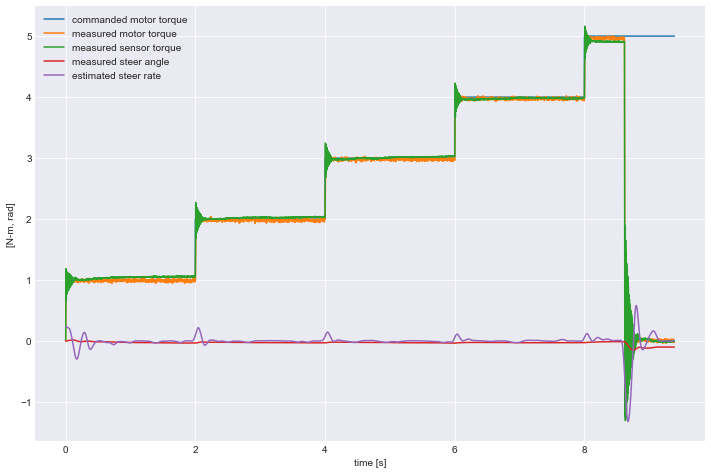

In [50]:
log = ps.ProcessedRecord('logs/positive_constant.pb.cobs')
plt.close('all')
plot_torques(log, rescale_kistler=True)
plt.show()

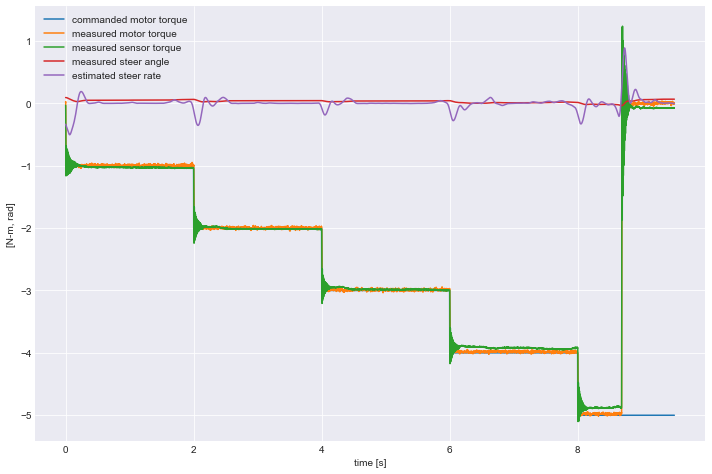

In [51]:
log = ps.ProcessedRecord('logs/negative_constant.pb.cobs')
plt.close('all')
plot_torques(log, rescale_kistler=True)
plt.show()